# De-identification & Re-identification

Download the dataset by clicking [here](https://jnear.github.io/cs295-data-privacy/homework/adult_with_pii.csv) and placing them in the same directory as this notebook.

The dataset is based on census data. The personally identifiable information (PII) is made up.

In [2]:
import pandas as pd
import numpy as np

In [3]:
adult = pd.read_csv("adult_with_pii.csv")
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# De-identification & Re-Identification

*De-identification* is the process of removing *identifying information* from a dataset. The term *de-identification* is sometimes used synonymously with the terms *anonymization* and *pseudonymization*.

Identifying information has no formal definition. It is usually understood to be information which would be used to identify us uniquely in the course of daily life - name, address, phone number, e-mail address, etc. As we will see later, it's *impossible* to formalize the concept of identifying information, because *all* information is identifying. The term *personally identifiable information (PII)* is often used synonymously with identifying information.

How do we de-identify information? Easy - we just remove the columns that contain identifying information!

In [4]:
adult_data = adult.drop(columns=['Name', 'SSN'])
adult_data.head()

,DOB,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,6/7/1988,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,8/6/1991,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,4/6/2009,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,9/16/1951,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We'll save some of the identifying information for later, when we'll use it as *auxiliary data* to perform a *re-identification* attack.

In [5]:
adult_pii = pd.read_csv("adult_pii.csv")
adult_pii.head()

,Name,DOB,Zip
0,Karrie Trusslove,9/7/1967,64152
1,Brandise Tripony,6/7/1988,61523
2,Brenn McNeely,8/6/1991,95668
3,Dorry Poter,4/6/2009,25503
4,Dick Honnan,9/16/1951,75387


## Linking Attacks

Imagine we want to determine the income of a friend from our de-identified data. Names have been removed, but we happen to know some auxiliary information about our friend. Our friend's name is Karrie Trusslove, and we know Karrie's date of birth and zip code.

In [6]:
adult_pii.head(1)

,Name,DOB,Zip
0,Karrie Trusslove,9/7/1967,64152


To perform a simple *linking attack*, we look at the overlapping columns between the dataset we're trying to attack, and the auxiliary data we know. In this case, both datasets have dates of birth and zip codes. We look for rows in the dataset we're attacking with dates of birth and zip codes that match Karrie's date of birth and zip code. If there is only one such row, we've found Karrie's row in the dataset we're attacking. In databases, this is called a *join* of two tables, and we can do it in Pandas using `merge`.

In [7]:
karries_row = adult_pii[adult_pii['Name'] == 'Karrie Trusslove']
karries_row

,Name,DOB,Zip
0,Karrie Trusslove,9/7/1967,64152


In [8]:
pd.merge(karries_row, adult_data, left_on=['DOB', 'Zip'], right_on=['DOB', 'Zip'])

,Name,DOB,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


Indeed, there is only one row that matches. We have used auxiliary data to re-identify an individual in a de-identified dataset, and we're able to infer that Karrie's income is less than $50k.

### How Hard is it to Re-Identify Karrie?

This scenario is made up, but linking attacks are surprisingly easy to perform in practice. How easy? It turns out that in many cases, just one data point is sufficient to pinpoint a row!

In [9]:
karries_new_row = adult_pii[adult_pii['Name'] == 'Karrie Trusslove'][['Name', 'Zip']]
karries_new_row

,Name,Zip
0,Karrie Trusslove,64152


In [10]:
pd.merge(karries_new_row, adult_data, left_on=['Zip'], right_on=['Zip'])

,Name,Zip,DOB,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,64152,9/7/1967,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


So ZIP code is sufficient **by itself** to allow us to re-identify Karrie. What about date of birth?

In [11]:
karries_newer_row = adult_pii[adult_pii['Name'] == 'Karrie Trusslove'][['Name', 'DOB']]
karries_newer_row

,Name,DOB
0,Karrie Trusslove,9/7/1967


In [12]:
pd.merge(karries_newer_row, adult_data, left_on=['DOB'], right_on=['DOB'])

,Name,DOB,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Karrie Trusslove,9/7/1967,67306,64,Private,171373,11th,7,Widowed,Farming-fishing,Unmarried,White,Female,0,0,40,United-States,<=50K
2,Karrie Trusslove,9/7/1967,62254,46,Self-emp-not-inc,119944,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K


This time, there are three rows returned - and we don't know which one is the real Karrie. But we've still learned a lot!

- We know that there's a 2/3 chance that Karrie's income is less than $50k
- We can look at the differences between the rows to determine what additional auxiliary informatino would *help* us to distinguish them (e.g. sex, occupation, marital status)

### Is Karrie Special?

How hard is it to re-identify others in the dataset? Is Karrie especially easy or especially difficult to re-identify? A good way to guage the effectiveness of this type of attack is to look at how "selective" certain pieces of data are - how good they are at narrowing down the set of potential rows which may belong to the target individual. For example, is it common for birthdates to occur more than once?

In [13]:
adult_pii['DOB'].value_counts().head(n=20)

10/23/1983    8
1/2/1984      7
6/21/1953     7
8/4/1969      7
6/7/1992      7
6/14/1977     7
2/6/1988      7
5/4/1959      7
7/22/1999     7
6/28/2005     7
6/12/2007     7
3/6/1983      7
3/6/1992      7
12/20/1970    7
6/5/1976      7
8/30/1986     7
8/12/1970     7
10/10/1997    7
3/13/1971     6
10/4/2009     6
Name: DOB, dtype: int64

This is encouraging - some dates of birth occur eight times! However, it's common for a few values to be represented many times, while the vast majority are actually pretty rare. We'd like to get an idea of how many dates of birth are likely to be useful in performing an attack, which we can do by looking at how common "unique" dates of birth are in the dataset.

In [14]:
adult_pii['DOB'].value_counts().hist();

We can do the same thing with ZIP codes, and we find the same results - ZIP code happens to be very selective in this dataset.

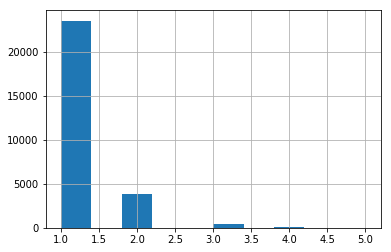

In [15]:
adult_pii['Zip'].value_counts().hist();

### How Many People can we Re-Identify?

In this dataset, how many people can we re-identify uniquely? We can use our auxiliary information to find out! First, let's see what happens with just dates of birth:

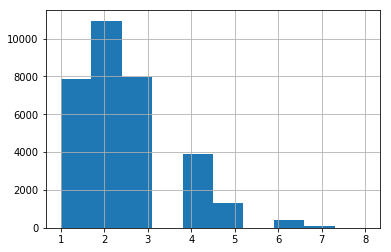

In [16]:
attack = pd.merge(adult_pii, adult_data, left_on=['DOB'], right_on=['DOB'])
attack['Name'].value_counts().hist();

So it's not possible to re-identify a majority of individuals using *just* date of birth. But, for the vast majority of records, we get between 1 and 3 records - so it might be possible to guess which record is the right one, or collect more information to narrow things down further. If we use both date of birth and ZIP, things get much better:

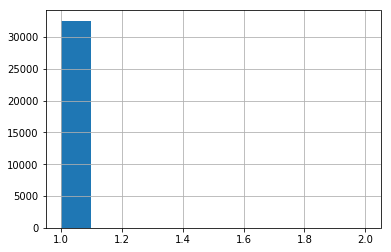

In [17]:
attack = pd.merge(adult_pii, adult_data, left_on=['DOB', 'Zip'], right_on=['DOB', 'Zip'])
attack['Name'].value_counts().hist();

When we use both pieces of information, we can re-identify **essentially everyone**. This is a surprising result, since we generally assume that many people share the same birthday, and many people live in the same ZIP code. It turns out that the *combination* of these factors is **extremely** selective. According to Latanya Sweeney's work, 87% of people in the US can be uniquely re-identified by the combination of date of birth, gender, and ZIP code.

Let's just check that we've actually re-identified *everyone*:

In [18]:
attack['Name'].value_counts().head()

Barnabe Haime       2
Antonin Chittem     2
Penelope Fauning    1
Sylvia Kenan        1
Sadella Gutowski    1
Name: Name, dtype: int64

Looks like we missed two people! In other words, in this dataset, only **two people** share a combination of ZIP code and date of birth.

## Aggregation

Another way to prevent the release of private information is to release only *aggregate* date.

In [21]:
adult['Age'].mean()

38.58164675532078

### Problem of Small Groups

This isn't very useful though! So mostly we see aggregated results broken down along some axis.

In [39]:
adult[['Education-Num', 'Age']].groupby('Education-Num').mean()

,Age
Education-Num,
1,42.764706
2,46.142857
3,42.885886
4,48.445820
5,41.060311
6,37.429796
7,32.355745
8,32.000000
9,38.974479


If the group is too small, we run into problems right away!!

In [41]:
adult[['Zip', 'Age']].groupby('Zip').mean().head()

,Age
Zip,
4,55.0
12,24.0
16,59.0
17,42.0
18,24.0


Consider: Many census statistics are at the block level, which means it might be easy to get auxiliary information to reverse an aggregation like "mean." How big a group is "big enough"? It's not easy to say!

### Differencing Attacks

The problem is *much* worse when you get to design your own queries. A "mean" query over a large group might seem fine:

In [47]:
adult['Age'].sum()

1256257

We might do another query over a large group:

In [48]:
adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

1256218

Combine them, and we're in trouble!

In [49]:
 adult['Age'].sum() - adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

39

This is a recurring theme.

- Releasing *data* that is useful makes ensuring *privacy* very difficult
- Distinguishing between *malicious* and *non-malicious* queries is not possible

## Summary

- A *linking attack* involves combining *auxiliary data* with *de-identified data* to *re-identify* individuals.
- In the simplest case, a linking attack can be performed via a *join* of two tables containing these datasets.
- Simple linking attacks are surprisingly effective:
  - Just a single data point is sufficient to narrow things down to a few records
  - The narrowed-down set of records helps suggest additional auxiliary data which might be helpful
  - Two data points are often good enough to re-identify a huge fraction of the population in a particular dataset
  - Three data points (gender, ZIP code, date of birth) uniquely identify 87% of people in the US